In [1]:
%matplotlib inline

In [2]:
from os.path import dirname, abspath, join
from os import getcwd
import sys

In [3]:
THIS_DIR = getcwd()
CLASS_DIR = abspath(join(THIS_DIR, '../../..', 'dsnclasses'))
sys.path.append(CLASS_DIR)

In [4]:
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

In [5]:
from ENOsmall import ENO
from CAPMr0 import CAPM
from NN2 import Net, DQN
from globalvar import *


Iteration 99:  WAKKANAI, 2009 
Best Average Reward 	=   -0.015
Average Reward 		=   -0.215


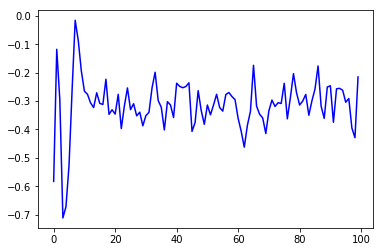

In [6]:
#TRAIN USING data from TOKYO, WAKKANAI and MINAMIDAITO FROM 2005 to 2014
dqn = DQN()

NO_OF_ITERATIONS = 100
best_avg_reward = -1000 #initialize best average reward to very low value
PFILENAME = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(8)) #create random filename
BFILENAME = "best"+PFILENAME + ".pt" #this file stores the best model
TFILENAME = "terminal"+PFILENAME + ".pt" #this file stores the last model

avg_reward_rec = [] #record the yearly average rewards over the entire duration of training
print('\nTRAINING IN PROGRESS')

for iteration in range(NO_OF_ITERATIONS):
    LOCATION = random.choice(['tokyo','wakkanai','minamidaito'])
    YEAR = random.choice(np.arange(2005,2015))
    capm = CAPM(LOCATION,YEAR,shuffle=True, trainmode=True) #instantiate the CAPM class
    capm.eno = ENO(LOCATION,YEAR, shuffle=True, day_balance=True) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object
    clear_output()
    print('\nIteration {}:  {}, {} '.format(iteration, LOCATION.upper(), YEAR))
    print("Best Average Reward \t= {:8.3f}".format(best_avg_reward))


    s, r, day_end, year_end = capm.reset()
    record = np.empty(4) #record for battery, henergy, reward and action

    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day

    while True:
        a = dqn.choose_action(s)
        
        # present state = [batt, enp, henergy]
        record = np.vstack((record, [s[0],s[2],r, a])) # record battery, henergy, reward and action for troubleshooting
                                                       # However, we are interested only in the reward

        # take action
        s_, r, day_end, year_end = capm.step(a)

        temp_transitions = np.hstack((s, [a, r], s_))
        transition_rec[capm.eno.hr-1,:] = temp_transitions

        if (day_end):
            transition_rec[:,5] = r #broadcast reward to all states
            decay_factor = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
            transition_rec[:,5] = transition_rec[:,5] * decay_factor #decay reward proportionately
            dqn.store_day_transition(transition_rec)

        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()

        if (year_end):
#             print("End of Year")
            break
        
        # transition to new state
        s = s_

    record = np.delete(record, 0, 0) #remove the first row which is garbage
    reward_rec = record[:,2]
    reward_rec = reward_rec[reward_rec != 0] #remove all zero rewards in the middle of the days
    print("Average Reward \t\t= {:8.3f}".format(np.mean(reward_rec)))
    
    # Check if reward beats the High Score and possible save it    
    if(best_avg_reward < np.mean(reward_rec)):
        best_avg_reward = np.mean(reward_rec)
        if (iteration > 20): #save the best models only after 20 iterations
            print("Saving Model")
            torch.save(dqn.eval_net.state_dict(), BFILENAME)

    # Log the average reward in avg_reward_rec
    avg_reward_rec = np.append(avg_reward_rec, np.mean(reward_rec))
    
# End of training
# Save the last model
torch.save(dqn.eval_net.state_dict(), TFILENAME) 

# Plot the average reward log
plt.plot(avg_reward_rec,'b')

In [9]:
#BFILENAME -> loads the best model
#TFILENAME -> loads the last model
MODELFILE = TFILENAME

In [ ]:
#Test the trained model for using greedy policy
TEST_LOCATION = 'tokyo'
TEST_YEAR = 2015
print('\nYear run test')

dqn = DQN()
capm = CAPM(TEST_LOCATION,TEST_YEAR, shuffle=False, trainmode=False)
capm.eno = ENO(TEST_LOCATION,TEST_YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object


# load the required model
dqn.eval_net.load_state_dict(torch.load(MODELFILE))
dqn.eval_net.eval()
print('Model Used: ',MODELFILE)

s, r, day_end, year_end = capm.reset()
yr_test_record = np.empty(4)

while True:
    a = dqn.choose_greedy_action(s)

    #state = [batt, enp, henergy, fcast]
    yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

    # take action
    s_, r, day_end, year_end = capm.step(a)

    if year_end:
        print("End of Test")
        break
       
    s = s_

yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage

#Plot the reward and battery for the entire year run
title = TEST_LOCATION.upper() + ',' + str(TEST_YEAR)

NO_OF_DAYS = capm.eno.NO_OF_DAYS
yr_test_reward_rec = yr_test_record[:,2]
yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
print('Average Reward for',title, '=', np.mean(yr_test_reward_rec))


fig = plt.figure(figsize=(24,10))
fig.suptitle(title, fontsize=15)

ax1 = fig.add_subplot(211)
ax1.plot(yr_test_reward_rec)
ax1.set_title("\n\nYear Run Reward")
ax1.set_ylim([-3,1])

ax2 = fig.add_subplot(212)
ax2.plot(yr_test_record[:,0],'r')
ax2.set_title("Year Run Battery")
ax2.set_ylim([0,1])
plt.sca(ax2)
plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))

fig.tight_layout()
plt.show()


Year run test
Model Used:  terminalZ8MSCSDS.pt


In [ ]:
#Plot the reward and battery for the entire year run on a day by day basis

TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
for DAY in range(0,10):#capm.eno.NO_OF_DAYS):
    START = DAY*24
    END = START+24
    
    daytitle = title + ' - DAY ' + str(DAY)
    fig = plt.figure(figsize=(16,4))
    st = fig.suptitle(daytitle)

    ax2 = fig.add_subplot(121)
    ax2.plot(yr_test_record[START:END,1],'g')
    ax2.set_title("HARVESTED ENERGY")
    plt.xlabel("Hour")
    ax2.set_ylim([0,1])

    #plot battery for year run
    ax1 = fig.add_subplot(122)
    ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
#     ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*capm.BOPT/capm.BMAX,'r--')
    ax1.plot(TIME_AXIS, np.ones(capm.eno.TIME_STEPS)*yr_test_record[START,0],'r--')
    ax1.text(0.1, 0.2, "BINIT = %.2f\n" %(yr_test_record[START,0]),fontsize=11, ha='left')
    ax1.text(0.1, 0.4, "TENP = %.2f\n" %(capm.BOPT/capm.BMAX-yr_test_record[END,0]),fontsize=11, ha='left')
    ax1.text(0.1, 0.3, "BMEAN = %.2f\n" %(np.mean(yr_test_record[START:END,0])),fontsize=11, ha='left')



    ax1.set_title("YEAR RUN TEST")
    if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
        ax1.text(0.1, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=13, ha='left')
    plt.xlabel("Hour")
    ax1.set_ylabel('Battery', color='r',fontsize=12)
    ax1.set_ylim([0,1])

    #plot actions for year run
    ax1a = ax1.twinx()
    ax1a.plot(yr_test_record[START:END,3])
    ax1a.set_ylim([0,N_ACTIONS])
    ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)
    
    fig.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.75)
    plt.show()